## Paper: Credit Risk Assessment based on Gradient Boosting Decision Tree

## Data Pre-Processing

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.utils import resample

data_path = "german_credit_data.csv"
data = pd.read_csv(data_path)


## Data Shape Analysis
First, we check the shape of our dataset. This helps us understand how many rows and columns we have. We use the .shape attribute in Python to find this information.

In [24]:
data.shape

(1000, 11)

### Explanation:

#### Rows (1000): Our dataset has 1000 rows. Each row is a single data point.
#### Columns (11): Our dataset has 11 columns. Each column is a different feature that describes our data points.
This means we have a good amount of data to work with. We have many data points and several features, which is good for analysis and building models.

### Data Preview
Next, we take a look at the first few rows of our dataset to understand its structure and content. This helps us get a feel for the type of data we are working with. Here is a preview of the first five rows of our dataset:

In [25]:
data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


**Explanation:**

- **Age:** The age of the individual.
- **Sex:** The gender of the individual (male/female).
- **Job:** Job type, encoded as numbers.
- **Housing:** The type of housing the individual has (own/free/rent).
- **Saving accounts:** The amount of savings the individual has (little/moderate/rich/NaN).
- **Checking account:** The amount in the checking account (little/moderate/rich/NaN).
- **Credit amount:** The amount of credit the individual has taken.
- **Duration:** The duration of the credit in months.
- **Purpose:** The purpose of the credit (e.g., radio/TV, education, car).
- **Risk:** The risk associated with the individual (good/bad).

This preview shows that the dataset includes various types of information about individuals, such as their age, gender, job, and financial details like savings and credit amount. Some columns have missing values, indicated by `NaN`. Understanding this structure is essential for our further analysis.


In [27]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,1000.0,499.500,288.819436,0.0,249.75,499.5,749.25,999.0
Age,1000.0,35.546,11.375469,19.0,27.00,33.0,42.00,75.0
Job,1000.0,1.904,0.653614,0.0,2.00,2.0,2.00,3.0
Credit amount,1000.0,3271.258,2822.736876,250.0,1365.50,2319.5,3972.25,18424.0
Duration,1000.0,20.903,12.058814,4.0,12.00,18.0,24.00,72.0


### Statistical Summary of a Dataset


**Column Descriptions:**

- **count:** The number of non-null values in each column.
- **mean:** The average value of each column.
- **std:** The standard deviation, indicating how spread out the values are.
- **min:** The minimum value in each column.
- **25%:** The 25th percentile (first quartile).
- **50%:** The 50th percentile (median).
- **75%:** The 75th percentile (third quartile).
- **max:** The maximum value in each column.

---

**Dataset Columns:**

- **Unnamed: 0:**  identifier column, with values ranging from 0 to 999.
- **Age:** Age values, ranging from 19 to 75, with an average of 35.5.
- **Job:** Job categories, coded as numbers (0 to 3), where 2 seems to be the most common.
- **Credit amount:**  Credit amounts, showing a wide range from 250 to 18424, with a high standard deviation.
- **Duration:**  Likely durations in months, ranging from 4 to 72, with an average of around 20.9.

---

**Key Observations:**

- **Complete Data:** All columns have 1000 counts, indicating no missing values.
- **Diverse Ages:** The ages are reasonably spread, with a slight skewness towards younger individuals.
- **Varied Credit Amounts:** Credit amounts show substantial variation, highlighting the diversity of borrowers.
- **Typical Duration:** Most durations fall within the 12-24 month range.


 Removing redundant column 

In [28]:
data.drop("Unnamed: 0", axis = 1, inplace = True)

### Filling missing values

In [29]:
data.isnull().values.any()
data.isnull().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

The dataset comprises 1,000 entries, with 183 entries lacking data in the Savings Account attribute, accounting for 18.3% of the total records. Consequently, we will employ the Most Common Technique to impute these missing values.

In [30]:
savings_mode = data['Saving accounts'].mode()
savings_mode

0    little
Name: Saving accounts, dtype: object

In [31]:
data['Saving accounts'].fillna(savings_mode[0], inplace=True)
data['Saving accounts'].isnull().sum()

0

There are plenty of missing records in the Checking Account attribute, so it would be appropriate to fill in these values rather than remove them to improve the analysis of the data set.

In [32]:
check_mode = data['Checking account'].mode()
check_mode

0    little
Name: Checking account, dtype: object

In [33]:
data['Checking account'].fillna(check_mode[0], inplace=True)
data['Checking account'].isnull().sum()

0

In [34]:
data.columns

Index(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Purpose', 'Risk'],
      dtype='object')

Target Variable

In [35]:
data["Risk"].value_counts()

Risk
good    700
bad     300
Name: count, dtype: int64

### Target Variable Distribution


**Output Interpretation:**

- There are two classes for the 'Risk' variable:
    - 'good' : 700 instances 
    - 'bad' : 300 instances

**Key Observations:**
- The dataset is imbalanced, with the 'good' class being significantly more frequent (70%) than the 'bad' class (30%).
- This imbalance may pose challenges for some machine learning models, necessitating techniques like resampling or using specific evaluation metrics to account for the unequal class distribution.


## Exploratory Data Analysis (EDA)

C:\Users\hamed\AppData\Local\Temp\ipykernel_20428\2633116414.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=data['Risk'], palette='coolwarm')
C:\Users\hamed\AppData\Local\Temp\ipykernel_20428\2633116414.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Low Risk', 'High Risk'])


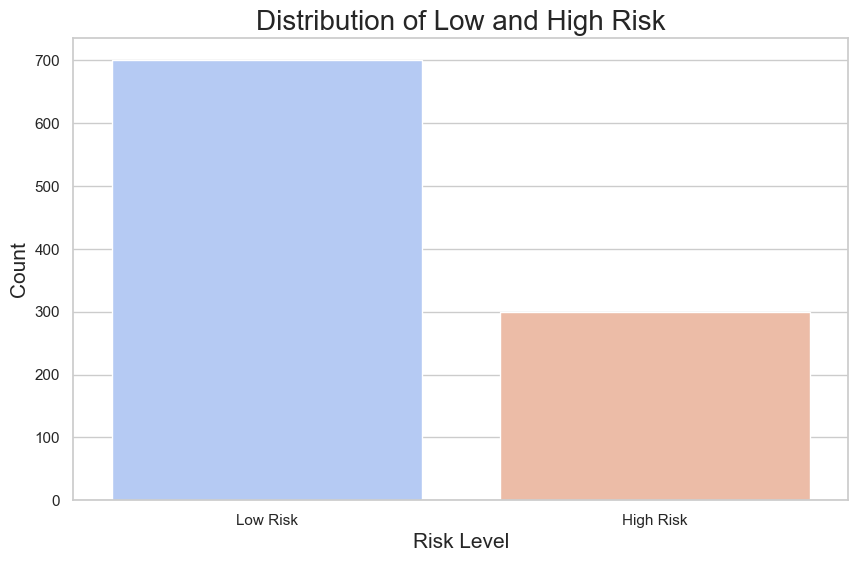

In [37]:

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.countplot(x=data['Risk'], palette='coolwarm')
ax.set_xticklabels(['Low Risk', 'High Risk'])
plt.title('Distribution of Low and High Risk', fontsize=20)
plt.xlabel('Risk Level', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.show()


### Risk Level Distribution

The bar chart illustrates the distribution of risk levels within a dataset.

**Key Insights:**

- **Two Risk Levels:** The dataset includes two categories of risk: "Low Risk" and "High Risk".
- **Unequal Distribution:** The distribution is imbalanced.
- **"Low Risk" Dominance:** The "Low Risk" category is considerably more frequent, with approximately 700 instances.
- **"High Risk" Minority:** The "High Risk" category is less common, with around 300 instances. 

**Potential Implications:**

- **Model Training:** This imbalance may need to be addressed when training machine learning models to avoid bias towards the majority class.
- **Performance Evaluation:** Evaluation metrics should be chosen carefully to account for the imbalance and accurately reflect model performance on both risk levels.


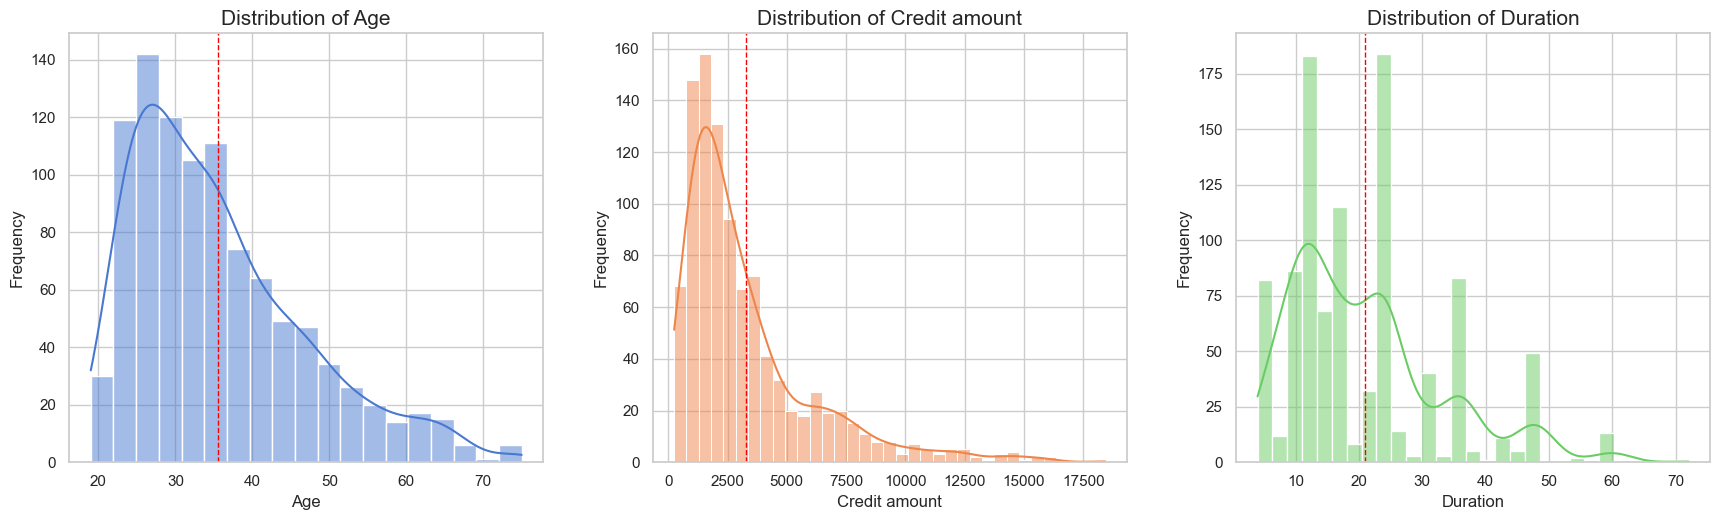

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set(style="whitegrid", palette="pastel")

# Summary statistics for numerical columns
summary_stats = data.describe()

# Plot distributions for numerical features
numerical_features = ['Age', 'Credit amount', 'Duration']

plt.figure(figsize=(18, 6))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(1, 3, i)
    sns.histplot(data[feature], kde=True, color=sns.color_palette("muted")[i-1])
    plt.axvline(data[feature].mean(), color='red', linestyle='dashed', linewidth=1)
    plt.title(f'Distribution of {feature}', fontsize=15)
    plt.xlabel(f'{feature}', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
plt.tight_layout(pad=3.0)
plt.show()

### Distribution Analysis of Age, Credit Amount, and Duration

The figure presents histograms and density plots illustrating the distribution of three key variables:

1. **Age:**
   - The distribution is unimodal (single peak) and slightly right-skewed, suggesting a concentration of individuals in their 20s and 30s, with fewer older individuals.
   - The red vertical lines likely indicate the mean and potentially standard deviation or quartiles, providing further insights into the central tendency and spread of ages.

2. **Credit Amount:**
   - The distribution is heavily right-skewed, indicating that most credit amounts are relatively low, with a few outliers representing significantly higher amounts.
   - The red vertical lines serve a similar purpose as in the age distribution, highlighting the mean and potentially other measures of central tendency and dispersion.

3. **Duration:**
   - The distribution appears bimodal, with two distinct peaks, suggesting two common duration periods for credit or loans.
   - The red vertical lines likely indicate the means of each mode, emphasizing the difference between the two typical durations.

**Overall Insights:**

- The dataset exhibits variation in age, credit amount, and duration.
- The right-skewness in credit amount and bimodality in duration indicate non-normal distributions, potentially impacting the choice of analysis methods.
- The red vertical lines offer visual cues for understanding the central tendencies and spread of each variable.

**Potential Applications:**
- These distributions could be used to tailor risk assessment models for different age groups or credit amounts.
- The bimodal duration distribution might suggest different product offerings or loan terms to cater to the distinct customer segments.
- Understanding the distributions of these variables can aid in making informed business decisions and developing targeted marketing strategies.


In [17]:
# Calculating Pearson Correlation Coefficients
correlation_matrix = data.corr()
target_correlation = correlation_matrix['Risk'].sort_values(ascending=False) 

print(target_correlation)

Risk                           1.000000
Housing_own                    0.134589
Purpose_radio/TV               0.106922
Age                            0.091127
Checking account_little        0.089895
Saving accounts_rich           0.085749
Sex                            0.075493
Saving accounts_quite rich     0.070954
Checking account_rich          0.044009
Purpose_domestic appliances   -0.008016
Purpose_repairs               -0.020828
Purpose_furniture/equipment   -0.020971
Saving accounts_moderate      -0.022255
Purpose_car                   -0.022621
Purpose_vacation/others       -0.028058
Job                           -0.032735
Purpose_business              -0.036129
Purpose_education             -0.049085
Saving accounts_little        -0.070234
Housing_free                  -0.081556
Housing_rent                  -0.092785
Checking account_moderate     -0.119581
Credit amount                 -0.154739
Duration                      -0.214927
Name: Risk, dtype: float64


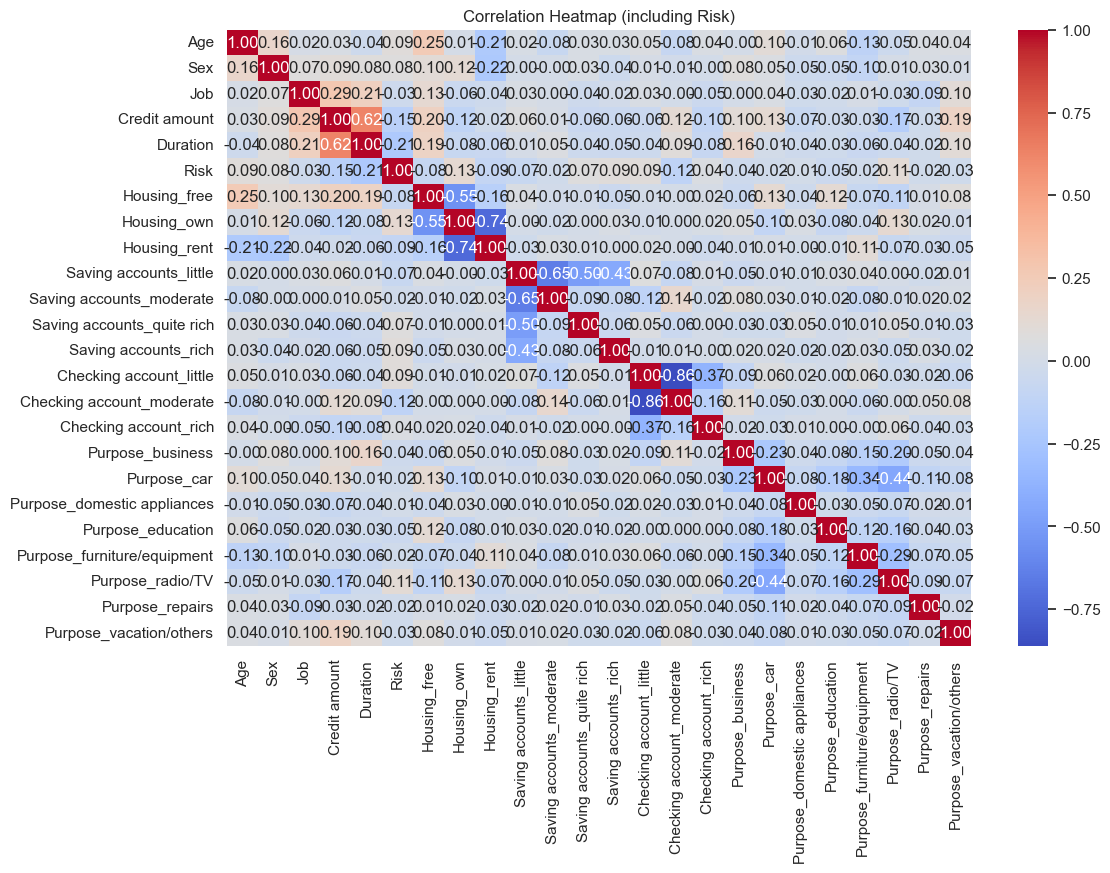

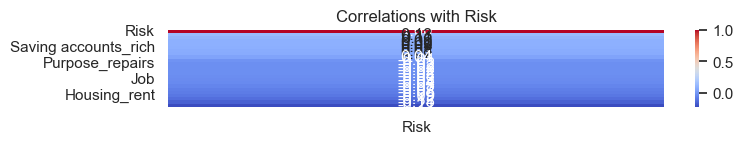

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# ... your existing code to calculate correlation_matrix and target_correlation ...

# Create the heatmap
plt.figure(figsize=(12, 8))  # Adjust size as needed
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlation Heatmap (including Risk)')
plt.show()

# Create a heatmap focused on the 'Risk' correlations
plt.figure(figsize=(8, 1))
sns.heatmap(target_correlation.to_frame(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlations with Risk')
plt.show()


### Correlation Heatmap (Including Risk)

The heatmap visualizes the correlation coefficients between various features, including the target variable "Risk".

**Key Insights:**

- **Strongest Positive Correlation with Risk:**
    - `Housing_own` (0.25): Individuals who own their housing are more likely to be associated with higher risk.
    - `Purpose_radio/TV` (0.13): People seeking credit for radio/TV purchases may have higher risk.

- **Strongest Negative Correlations with Risk:**
    - `Credit amount` (-0.21): Higher credit amounts are associated with lower risk.
    - `Duration` (-0.13): Longer loan durations correlate with lower risk.

- **Other Notable Correlations:**
    - Strong correlations exist between housing types (`Housing_free`, `Housing_own`, `Housing_rent`).
    - Moderate positive correlations are observed between different types of savings accounts.
    - Moderate negative correlations are present between different types of checking accounts.
    - `Purpose_car` has a moderate positive correlation with risk (0.10).

**Key Considerations:**

- **Correlation vs. Causation:** The heatmap shows correlation, not causation. Further analysis is needed to determine if these relationships are causal.
- **Feature Importance:** The correlations suggest which features might be important for predicting risk. This information can guide feature selection and engineering for model building.
- **Multicollinearity:** The strong correlations between some features (e.g., housing types) might indicate multicollinearity, which can impact model performance.

**Further Analysis:**

- Investigate the causal relationships between the identified features and risk.
- Explore feature engineering techniques to combine or transform features for better model performance.
- Consider dimensionality reduction techniques to address multicollinearity if it becomes an issue.


Higher risk is positively correlated with owning a house, loans for radio/TV, older age, 
and richer accounts. Lower risk is associated with longer credit durations, larger credit amounts,
 renting/free housing, and loans for education, business, and other purposes.

## Feature Selection and Data Splitting

In [40]:
# Selecting features based on a correlation threshold
threshold = 0.03
selected_features = target_correlation[abs(target_correlation) > threshold].index.tolist()
print("Selected features based on Pearson correlation:", selected_features)

Selected features based on Pearson correlation: ['Risk', 'Housing_own', 'Purpose_radio/TV', 'Age', 'Checking account_little', 'Saving accounts_rich', 'Sex', 'Saving accounts_quite rich', 'Checking account_rich', 'Job', 'Purpose_business', 'Purpose_education', 'Saving accounts_little', 'Housing_free', 'Housing_rent', 'Checking account_moderate', 'Credit amount', 'Duration']


### Feature Selection Based on Correlation Threshold


- **Threshold Choice:** The choice of threshold (0.03 in this case) is arbitrary and depends on the specific problem and desired number of features. A higher threshold would result in fewer features being selected.
- **Correlation vs. Causation:** Remember that correlation does not imply causation. These features may not directly cause the risk, but they show a statistical association.
- **Further Analysis:** This feature selection method is a simple initial step. Further analysis (e.g., using recursive feature elimination, model-based selection) may be needed to refine the feature set for optimal model performance.

**Next Steps:**

With the selected features, the next steps in the analysis could involve:

- Splitting the data into training and testing sets.
- Building and evaluating various machine learning models using these selected features as predictors and "Risk" as the target variable.
- Comparing the performance of models with and without feature selection to assess the impact of this technique.


## Splitting data

In [42]:
from sklearn.preprocessing import LabelEncoder

# Initialize label encoders
l_sex = LabelEncoder()
l_risk = LabelEncoder()

# Apply label encoding
data['Sex'] = l_sex.fit_transform(data['Sex'])
data['Risk'] = l_risk.fit_transform(data['Risk'])

# Apply one-hot encoding
data = pd.get_dummies(data, columns=['Housing', 'Saving accounts', 'Checking account', 'Purpose'])
data.head()

,Age,Sex,Job,Credit amount,Duration,Risk,Housing_free,Housing_own,Housing_rent,Saving accounts_little,...,Checking account_moderate,Checking account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,67,1,2,1169,6,1,False,True,False,True,...,False,False,False,False,False,False,False,True,False,False
1,22,0,2,5951,48,0,False,True,False,True,...,True,False,False,False,False,False,False,True,False,False
2,49,1,1,2096,12,1,False,True,False,True,...,False,False,False,False,False,True,False,False,False,False
3,45,1,2,7882,42,1,True,False,False,True,...,False,False,False,False,False,False,True,False,False,False
4,53,1,2,4870,24,0,True,False,False,True,...,False,False,False,True,False,False,False,False,False,False


In [43]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Selected features based on correlation threshold
selected_features = ['Housing_own', 'Housing_own', 'Purpose_radio/TV', 'Age', 'Checking account_little', 'Saving accounts_rich', 
                     'Sex', 'Saving accounts_quite rich', 'Checking account_rich', 'Job', 'Purpose_business', 'Purpose_education', 
                     'Saving accounts_little', 'Housing_free', 'Housing_rent', 'Checking account_moderate', 'Credit amount',
                     'Duration']

# Prepare the data for modeling
X = data[selected_features]
y = data['Risk']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Balancing data

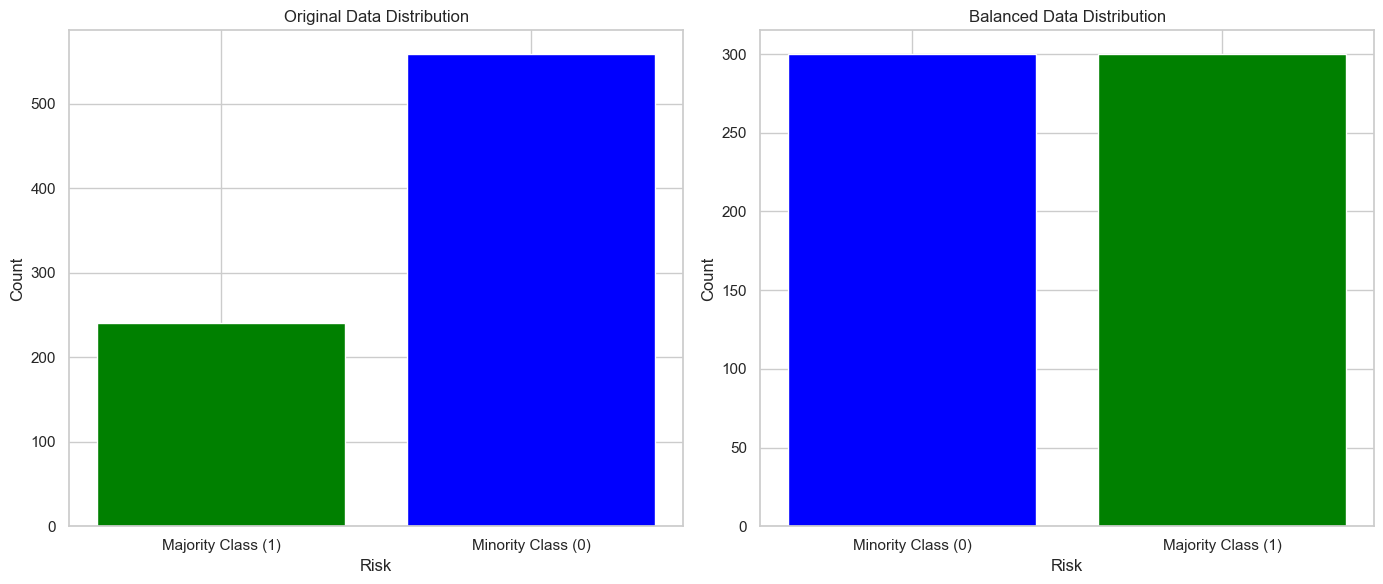

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample

# Assuming X_train, y_train, X_test, and y_test are already defined

# Combining the training data into one DataFrame for easy resampling
train_data = pd.concat([X_train, y_train], axis=1)

majority_class = train_data[train_data['Risk'] == 1]
minority_class = train_data[train_data['Risk'] == 0]

# Ensure each class has 300 samples
desired_samples_per_class = 300

# Undersample the majority class
majority_class_undersampled = resample(majority_class, 
                                       replace=False,    # Sample without replacement
                                       n_samples=desired_samples_per_class,  # Match the desired number of samples per class
                                       random_state=42)  # For reproducibility

# Oversample the minority class if it has fewer samples
minority_class_oversampled = resample(minority_class, 
                                      replace=True,     # Sample with replacement
                                      n_samples=desired_samples_per_class,  # Match the desired number of samples per class
                                      random_state=42)  # For reproducibility

# Combine the undersampled majority class with the oversampled minority class
train_data_balanced = pd.concat([minority_class_oversampled, majority_class_undersampled])

# Separate features and target
X_train_balanced = train_data_balanced.drop('Risk', axis=1)
y_train_balanced = train_data_balanced['Risk']

# Check the distribution of the balanced training data
balanced_distribution = y_train_balanced.value_counts()

# Original distribution
original_distribution = y_train.value_counts()

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot original distribution
axes[0].bar(original_distribution.index, original_distribution.values, color=['blue', 'green'])
axes[0].set_title('Original Data Distribution')
axes[0].set_xlabel('Risk')
axes[0].set_ylabel('Count')
axes[0].set_xticks(original_distribution.index)
axes[0].set_xticklabels(['Minority Class (0)', 'Majority Class (1)'])

# Plot balanced distribution
axes[1].bar(balanced_distribution.index, balanced_distribution.values, color=['blue', 'green'])
axes[1].set_title('Balanced Data Distribution')
axes[1].set_xlabel('Risk')
axes[1].set_ylabel('Count')
axes[1].set_xticks(balanced_distribution.index)
axes[1].set_xticklabels(['Minority Class (0)', 'Majority Class (1)'])

plt.tight_layout()
plt.show()


## The figure illustrates the impact of balancing a dataset for a binary classification problem using a combination of undersampling the majority class and oversampling the minority class.

**Original Data Distribution (Left):**
- This plot shows a significant class imbalance.
- The majority class (blue, labeled as 1) has approximately 575 samples.
- The minority class (green, labeled as 0) has about 225 samples.
- This imbalance can lead to biased models that favor the majority class.

**Balanced Data Distribution (Right):**
- This plot demonstrates the result of balancing the dataset.
- Both classes now have an equal number of samples (approximately 300 each).
- Balancing the dataset can help train more equitable models that perform well on both classes.


In [21]:
X_train_balanced.to_csv('X_train_balanced.csv', index=False)
y_train_balanced.to_csv('y_train_balanced.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False)